<a href="https://colab.research.google.com/github/zevan07/DS-Unit-2-Tree-Ensembles/blob/master/Trees%2C_Forests%2C_and_Pumps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.7MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import seaborn as sns

In [0]:
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/'
train_features = pd.read_csv(WEB + 'train_features.csv')
train_labels = pd.read_csv(WEB + 'train_labels.csv')
test_features = pd.read_csv(WEB + 'test_features.csv')
sample_submission = pd.read_csv(WEB + 'sample_submission.csv')

In [4]:
X_train = train_features
y_train = train_labels['status_group']

X_train, X_val, y_train, y_val, = train_test_split(
    X_train, y_train, train_size=.8, test_size=.2,
    stratify=y_train, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [0]:
train = pd.merge(train_features, train_labels)
test = test_features

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                             stratify=train['status_group'], random_state=42)

In [0]:
def wrangle(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # years from construction to date recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    
    # drop random and unvarying columns
    X = X.drop(columns=['recorded_by', 'id'])
    
    # drop duplicate columns
    X = X.drop(columns='quantity_group')
    
    
    
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
        
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
target = 'status_group'

train_features = train.drop(columns=[target])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

In [11]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(ce.OrdinalEncoder(),
                         SimpleImputer(strategy='median'),
                         RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8089225589225589


## Decision Tree Classifier

In [9]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(ce.OrdinalEncoder(),
                         SimpleImputer(strategy='median'),
                         DecisionTreeClassifier(max_depth=16, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7724747474747474


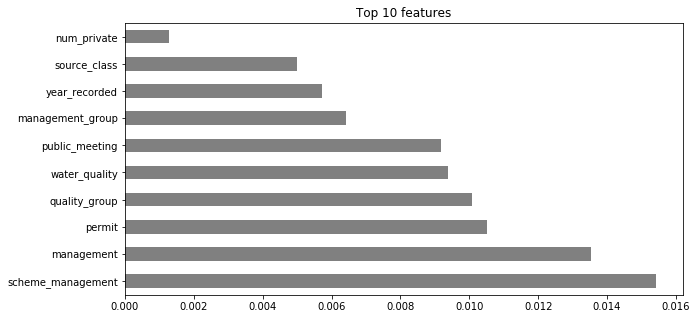

In [12]:
# get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 10
plt.figure(figsize = (10, n/2))
plt.title(f'Top {n} features')
importances.sort_values(ascending=False)[-n:].plot.barh(color='grey')

## Random Forest Classifier

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(ce.OrdinalEncoder(),
                         SimpleImputer(strategy='median'),
                         RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

In [0]:
# get feature importances
encoder = pipeline.named_steps['ordinalencoder']
tree = pipeline.named_steps['randomforestclassifier']
feature_names = encoder.transform(X_val).columns
importances = pd.Series(tree.feature_importances_, feature_names)

n = 10
plt.figure(figsize = (10, n/2))
plt.title(f'Top {n} features')
importances.sort_values(ascending=False)[-n:].plot.barh(color='grey')

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(ce.OrdinalEncoder(),
                         SimpleImputer(strategy='median'),
                         RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

### Submission CSV

In [0]:
# y_pred = pipeline.predict(X_test)

# # Write submission csv file
# submission = sample_submission.copy()
# submission['status_group'] = y_pred
# submission.to_csv('submission-05.csv', index=False)

## Exploring Feature Effects

In [0]:
feature = 'quantity'

In [0]:
X_train[feature].value_counts()

In [0]:
for feature in categorical_features:
    plt.figure()
    sns.barplot(x=train[feature], 
                y=train['status_group'] == 'functional');

In [0]:
for feature in numeric_features:
    plt.figure()
    plt.scatter(train[feature], train['status_group'])
    plt.title(feature)

## Confusion Matrix

In [0]:
y_pred = pipeline.predict(X_val)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[5696,  205,  551],
       [ 422,  294,  147],
       [ 866,   79, 3620]])

In [16]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [17]:
pipeline.named_steps['randomforestclassifier'].classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

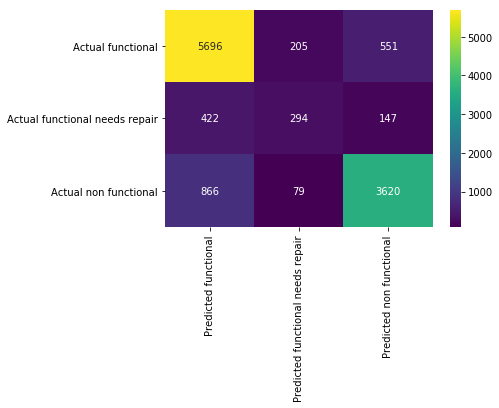

In [18]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

## ROC AUC or Area Under the Receiver Operating Characteristic Curve

## Work from "Visualizing Machine Learning Thresholds"

### Applied to article's data

In [0]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')

df.head()

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

# df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')

# # Preprocessing
# df.columns = [c.lower().replace(' ', '_').replace('?','').replace("'", "") for c in df.columns]

# state_encoder = LabelEncoder()
# df.state = state_encoder.fit_transform(df.state)

# del df['phone_number']
# binary_columns = ['international_plan', 'voice_mail_plan', 'churn']
# for col in binary_columns:
#     df[col] = df[col].map({
#          'no': 0
#     ,    'False.': 0
#     ,    'yes': 1
#     ,    'True.': 1
#     })
    
# Build classifier and get predictions
clf = RandomForestClassifier(n_estimators=50, oob_score=True)
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]
labels = df['churn']

train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)

clf.fit(train_signals, train_labels)

predictions = clf.predict_proba(test_signals)[:,1]

In [0]:
precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
thresholds = np.append(thresholds, 1)

queue_rate = []